## Notebook summary

This notebook begins the modeling process for our data set. I will work through several different machine learning algorithms and choose which models are worthy of the final cut. 5-fold cross-validation is applied to models to narrow down models I'm interested in. `finalize-model.ipynb` makes the final decision of which model to use based on test data which is not used in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keplerutils
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # Support vector machines
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn.naive_bayes import BernoulliNB # Bernoulli Naive Bayes
from sklearn.naive_bayes import MultinomialNB # Multinomial Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Decision tree
from sklearn.linear_model import SGDClassifier # Stochastic gradient descent 
from sklearn.ensemble import AdaBoostClassifier # ADABoost

from imblearn.over_sampling import SMOTE

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('objects-of-interest.csv', index_col = 0)

In [4]:
df = df.drop(labels=['rowid', 'kepoi_name', 'pdisposition', 'tce_delivname', 'kepid'], axis=1)

In [5]:
df = df.drop(labels=['tce_plnt_num'], axis=1)

In [6]:
df['disposition'] = df['disposition'].apply(lambda x: keplerutils.encode_response(x))

In [7]:
df.to_csv('final.csv')

In the `disposition` column, 1 means an object of interest was confirmed as an exoplanet, and a 0 means an object of interest was not an exoplanet.

## Models to test:

* KNN
* Logistic regression
* Random forest
* Naive Bayes (Gaussian, Bernoulli)
* Decision tree
* Gradient descent (vanilla, stochastic, mini batch)
* SVM 
* Gradient boosting

First we need to establish a train test split of our data and save it to a dataframe.

In [13]:
X_train_res, X_test, y_train_res, y_test = keplerutils.combo_resample(df)

## K Nearest Neighbors

In [568]:
def knnCV(X_train_res, y_train_res):
    '''Splits data in to test and training data, 10-fold cross-validates on training data,
       calculates scoring metric, and returns the mean of that scoring metric
       ----Parameters----
       df: Pandas dataframe with response in 0th column, features in rest of columns
       ----Returns----
       np.mean(scores): the mean of the scores calculated by cross_val_score
    '''     
    pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
    
    tuning_params = {'kneighborsclassifier__n_neighbors': [i for i in range(2, 20)],
                     'kneighborsclassifier__weights': ['distance', 'uniform']}
    
    g = RandomizedSearchCV(pipe, tuning_params, scoring='recall_micro', cv=5, n_jobs = -1)
    
    g.fit(X_train_res, y_train_res)
    
    y_preds = g.predict(X_test)
    
    print(classification_report(y_test, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean AUC grid scores: ', g.cv_results_['mean_test_score'])

In [569]:
knnCV(X_train_res, y_train_res)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1357
           1       0.65      0.86      0.74       686

   micro avg       0.80      0.80      0.80      2043
   macro avg       0.79      0.82      0.79      2043
weighted avg       0.83      0.80      0.81      2043

Best parameters:  {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 3}
Mean AUC grid scores:  [0.85348911 0.85380486 0.83517524 0.84685823 0.85617303 0.85080518
 0.85901484 0.86264604 0.85033154 0.84449005]


## Logistic Regression

In [566]:
def logisticCV(X_train_res, y_train_res):
    '''
        Performs logistic regression with 5-fold cross validated grid search on training data.
        Prints AUC scores and best parameters.
       ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
        '''
    X_train_res, X_test, y_train_res, y_test = split_and_upsample(df)
    
    pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', max_iter=1000))
            
    tuning_params = {'logisticregression__C': [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}
    
    g = GridSearchCV(pipe, tuning_params, scoring='accuracy', cv=5, n_jobs = -1)
    
    g.fit(X_train_res, y_train_res)
    
    y_preds = g.predict(X_test)
    
    print(classification_report(y_test, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])

In [567]:
logisticCV(X_train_res, y_train_res)

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1381
           1       0.69      0.91      0.79       662

   micro avg       0.84      0.84      0.84      2043
   macro avg       0.82      0.86      0.83      2043
weighted avg       0.87      0.84      0.85      2043

Best parameters:  {'logisticregression__C': 10000.0}
Mean ROC grid scores:  [0.81148584 0.83503023 0.8450525  0.84743875 0.84887051 0.85252943
 0.85364302 0.85316577 0.85300668 0.85332485]


## Random Forest

In [10]:
def RFCCV(X_train_res, y_train_res):
    '''
        Performs Random Forest Classificiation with 5 fold cross validation on training data.
        Prints ROC and and best parameters.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''                
    pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
        
    tuning_params = {'randomforestclassifier__max_depth': [50, 100, 150, 200, 250, 300], 
                     'randomforestclassifier__n_estimators': [50, 100, 150, 200, 250, 300],
                     'randomforestclassifier__max_features': [2, 4, 6, 8, 10, 12, 14]
                    }
    
    g = RandomizedSearchCV(pipe, tuning_params, scoring='recall_micro', cv=5, n_jobs = -1)
    
    g.fit(X_train_res, y_train_res)
    
    y_preds = g.predict(X_test)
    
    print(classification_report(y_test, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])
    
    return g.predict_proba(X_test)

In [14]:
probs = RFCCV(X_train_res, y_train_res)

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1131
           1       0.87      0.81      0.84       572

   micro avg       0.89      0.89      0.89      1703
   macro avg       0.89      0.87      0.88      1703
weighted avg       0.89      0.89      0.89      1703

Best parameters:  {'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__max_depth': 250}
Mean ROC grid scores:  [0.95330672 0.95209165 0.95157091 0.95330672 0.95729908 0.9579934
 0.9534803  0.95608401 0.95226523 0.95591043]


In [418]:
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

In [421]:
roc_auc_score(y_test, preds)

0.9562982999284565

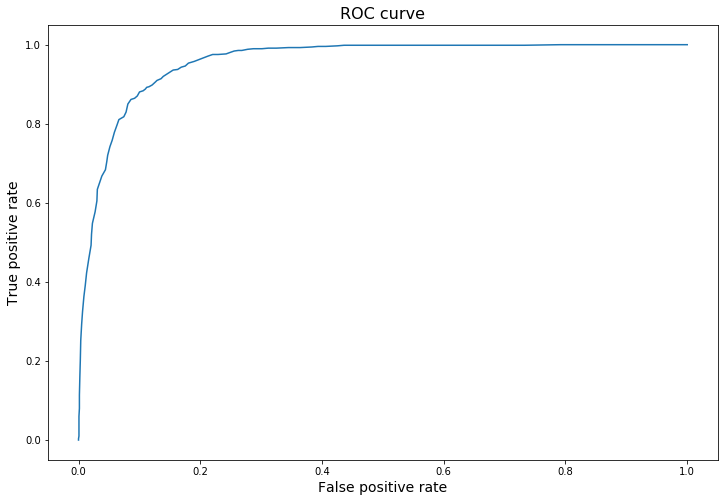

In [428]:
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate', size=14)
plt.ylabel('True positive rate', size=14)
plt.title('ROC curve', size=16);

## Support vector machines

In [481]:
def SVMCV(X_train_res, y_train_res):
    pipe = make_pipeline(StandardScaler(), SVC(kernel='sigmoid'))
    
    
    tuning_params = {'svc__C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
                     'svc__gamma': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]}
    
    g = RandomizedSearchCV(pipe, tuning_params, scoring='recall_micro', cv=5)
    
    g.fit(X_train_res, y_train_res)
    
    print('Best parameters: ', g.best_params_)
    
    print('Recall score for best parameters: ', g.best_score_)

In [485]:
df['disposition'].value_counts()

0    4524
1    2285
Name: disposition, dtype: int64

In [482]:
SVMCV(X_train_res, y_train_res)

Best parameters:  {'svc__gamma': 0.001, 'svc__C': 100.0}
Recall score for best parameters:  0.8383328070729397


## Gaussian Naive Bayes

In [521]:
def GNBCV(X_train_res, y_train_res):
    '''
        Performs Gaussian Naive Bayes classification with 5 fold cross validation on training data and
        prints f1 macro score.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''
        
    pipe = make_pipeline(StandardScaler(), GaussianNB())
    
    pipe.fit(X_train_res, y_train_res)
    
    scores = cross_val_score(pipe, X_train_res, y_train_res, cv=5, scoring='roc_auc')
    
    y_preds = pipe.predict(X_test)
    
    print('Recall score out of sample:', recall_score(y_preds, y_test))
    
    print('Cross validation ROC:', np.mean(scores))

In [522]:
GNBCV(X_train_res, y_train_res)

Recall score out of sample: 0.5505430242272348
Cross validation ROC: 0.8998524764439837


## Bernoulli Naive Bayes

In [228]:
def BNBCV(X_train_res, y_train_res):
    '''
        Performs Bernoulli Naive Bayes classification with 5 fold cross validation on training data and
        prints f1 macro score.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''
        
    pipe = make_pipeline(StandardScaler(), BernoulliNB())
    
    pipe.fit(X_train_res, y_train_res)
    
    scores = cross_val_score(pipe, X_train_res, y_train_res, cv=5, scoring='roc_auc')
    
    print('Cross validation ROC:', np.mean(scores))

In [519]:
BNBCV(X_train_res, y_train_res)

Cross validation ROC: 0.8155598320037711


# Decision Tree

In [562]:
def decisiontreeCV(X_train_res, y_train_res):
    '''
        Performs Decision Tree Classification with 5 fold cross validation on training data.
        Prints ROC and and best parameters.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''
    
    pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier())
    
    tuning_params = {'decisiontreeclassifier__max_depth': [50, 100, 150, 200, 250, 300],
                     'decisiontreeclassifier__max_features': [2, 4, 6, 8]}
    
    g = RandomizedSearchCV(pipe, tuning_params, cv=5, scoring='recall_micro')
    
    g.fit(X_train_res, y_train_res)
    
    y_preds = g.predict(X_test)
    
    print(classification_report(y_test, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])

In [563]:
decisiontreeCV(X_train_res, y_train_res)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1357
           1       0.79      0.83      0.81       686

   micro avg       0.87      0.87      0.87      2043
   macro avg       0.85      0.86      0.86      2043
weighted avg       0.87      0.87      0.87      2043

Best parameters:  {'decisiontreeclassifier__max_features': 8, 'decisiontreeclassifier__max_depth': 150}
Mean ROC grid scores:  [0.90101042 0.88680139 0.89864225 0.88980107 0.90827281 0.90037891
 0.90085254 0.90274708 0.88980107 0.87859173]


## Stochastic Gradient Descent

In [469]:
def SGDCV(X_train_res, y_train_res):
    '''
        Performs Stochastic Gradient Descent Classification with 5 fold cross validation on 
        training data. Prints ROC and and best parameters.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''
    
    pipe = make_pipeline(StandardScaler(), SGDClassifier())
    
    tuning_params = {'sgdclassifier__alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]}
    
    g = RandomizedSearchCV(pipe, tuning_params, cv=5, scoring='recall_micro')
    
    g.fit(X_train_res, y_train_res)
    
    print('Best parameters: ', g.best_params_)
    
    print('Recall score for best parameters: ', g.best_score_)

In [470]:
SGDCV(X_train_res, y_train_res)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

Best parameters:  {'sgdclassifier__alpha': 0.001}
Recall score for best parameters:  0.8215977265550994


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

## Gradient boosting

In [560]:
def GBCV(X_train_res, y_train_res):
    pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier())
        
    tuning_params = {'gradientboostingclassifier__learning_rate': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                     'gradientboostingclassifier__max_depth': [50, 100, 150, 200],
                     'gradientboostingclassifier__max_features': [2, 4, 6, 8, 10]}
    
    g = RandomizedSearchCV(pipe, tuning_params, cv=5, scoring='recall_micro')
    
    g.fit(X_train_res, y_train_res)
    
    y_preds = g.predict(X_test)
    
    print(classification_report(y_test, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])

In [561]:
GBCV(X_train_res, y_train_res)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1357
           1       0.89      0.88      0.88       686

   micro avg       0.92      0.92      0.92      2043
   macro avg       0.91      0.91      0.91      2043
weighted avg       0.92      0.92      0.92      2043

Best parameters:  {'gradientboostingclassifier__max_features': 4, 'gradientboostingclassifier__max_depth': 100, 'gradientboostingclassifier__learning_rate': 0.001}
Mean ROC grid scores:  [0.94537417 0.89169561 0.90211557 0.88664351 0.90053679 0.94395327
 0.89769498 0.94063783 0.90369435 0.89532681]


# Adaboost

In [579]:
def ABCV(X_train_res, y_train_res):
    pipe = make_pipeline(StandardScaler(), AdaBoostClassifier())
        
    tuning_params = {'adaboostclassifier__learning_rate': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                     'adaboostclassifier__n_estimators': [50, 100, 150, 200]}
    
    g = RandomizedSearchCV(pipe, tuning_params, cv=5, scoring='recall_micro')
    
    g.fit(X_train_res, y_train_res)
    
    y_preds = g.predict(X_test)
    
    print(classification_report(y_test, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])

In [580]:
ABCV(X_train_res, y_train_res)

dict_keys(['memory', 'steps', 'standardscaler', 'adaboostclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'adaboostclassifier__algorithm', 'adaboostclassifier__base_estimator', 'adaboostclassifier__learning_rate', 'adaboostclassifier__n_estimators', 'adaboostclassifier__random_state'])


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)


              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1357
           1       0.80      0.91      0.85       686

   micro avg       0.90      0.90      0.90      2043
   macro avg       0.88      0.90      0.89      2043
weighted avg       0.90      0.90      0.90      2043

Best parameters:  {'adaboostclassifier__n_estimators': 200, 'adaboostclassifier__learning_rate': 0.1}
Mean ROC grid scores:  [0.73397537 0.5        0.91158825 0.73397537 0.5        0.73397537
 0.90101042 0.90827281 0.73397537 0.84070098]
